In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DATASET_PATH = "/content/drive/MyDrive/Medicinal_Leaf_Dataset"
print("Dataset exists:", os.path.exists(DATASET_PATH))

folders = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
folders = sorted(folders)

print("Total class folders:", len(folders))
print("First 10 folders:", folders[:10])


Dataset exists: True
Total class folders: 15
First 10 folders: ['Ashok', 'Basil', 'Cordia', 'Debdaru', 'Heaven_Lotus', 'Jarul', 'Mastwood', 'Minjiri', 'Nageshor', 'Neem']


In [3]:
import os

OUT_DIR = "/content/drive/MyDrive/leaf_cbir_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

print("Output folder:", OUT_DIR)
print("Current files:", os.listdir(OUT_DIR))


Output folder: /content/drive/MyDrive/leaf_cbir_outputs
Current files: []


In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

IMG_SIZE = 128

images = []
filepaths = []

classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Classes:", classes)

for class_name in classes:
    class_dir = os.path.join(DATASET_PATH, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(class_dir, fname)
            img = load_img(p, target_size=(IMG_SIZE, IMG_SIZE))
            img = img_to_array(img).astype("float32") / 255.0
            images.append(img)
            filepaths.append(p)

images = np.array(images, dtype="float32")

print("Total images:", images.shape)
print("Total paths :", len(filepaths))
print("Sample path :", filepaths[0])


Classes: ['Ashok', 'Basil', 'Cordia', 'Debdaru', 'Heaven_Lotus', 'Jarul', 'Mastwood', 'Minjiri', 'Nageshor', 'Neem', 'Punnag', 'Royna', 'Telakucha', 'Thankuni', 'Vasaka']
Total images: (6096, 128, 128, 3)
Total paths : 6096
Sample path : /content/drive/MyDrive/Medicinal_Leaf_Dataset/Ashok/ashok_117.jpg


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(images, test_size=0.2, random_state=42)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)


Train: (4876, 128, 128, 3)
Val  : (1220, 128, 128, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

LATENT_DIM = 256

inp = layers.Input(shape=(128,128,3))

# -------- Encoder --------
x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
x = layers.MaxPooling2D(2, padding="same")(x)      # 64x64
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(2, padding="same")(x)      # 32x32
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(2, padding="same")(x)      # 16x16
x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(2, padding="same")(x)      # 8x8

x = layers.Flatten()(x)
latent = layers.Dense(LATENT_DIM, name="latent_vector")(x)

# -------- Decoder --------
x = layers.Dense(8*8*256, activation="relu")(latent)
x = layers.Reshape((8, 8, 256))(x)

x = layers.UpSampling2D(2)(x); x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D(2)(x); x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D(2)(x); x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D(2)(x); x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

out = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(x)

autoencoder = Model(inp, out, name="ConvAutoencoder")
encoder = Model(inp, latent, name="Encoder")

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanSquaredError(name="mse")]
)

# ---- Auto-save best weights to Drive ----
CKPT_PATH = os.path.join(OUT_DIR, "ae_best.weights.h5")

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    CKPT_PATH,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1
)

early_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True, monitor="val_loss"
)

reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(
    patience=2, factor=0.5, min_lr=1e-6, monitor="val_loss"
)

print("Checkpoint will save to:", CKPT_PATH)
autoencoder.summary()


Checkpoint will save to: /content/drive/MyDrive/leaf_cbir_outputs/ae_best.weights.h5


Model: "ConvAutoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16384)          │     4,210,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771,907 (37.28 MB)

 Trainable params: 9,771,907 (37.28 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
EPOCHS = 12

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[checkpoint_cb, early_cb, reduce_cb]
)


Epoch 1/12
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0488 - mse: 0.0488
Epoch 1: val_loss improved from inf to 0.01842, saving model to /content/drive/MyDrive/leaf_cbir_outputs/ae_best.weights.h5
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 182ms/step - loss: 0.0487 - mse: 0.0487 - val_loss: 0.0184 - val_mse: 0.0184 - learning_rate: 0.0010
Epoch 2/12
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0144 - mse: 0.0144
Epoch 2: val_loss improved from 0.01842 to 0.00881, saving model to /content/drive/MyDrive/leaf_cbir_outputs/ae_best.weights.h5
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0088 - val_mse: 0.0088 - learning_rate: 0.0010
Epoch 3/12
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0078 - mse: 0.0078
Epoch 3: val_loss improved from 0.00881 to 0.00656, saving model to /content/drive/MyDrive/leaf_cbir_outputs/ae_best.weights.h5
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0066 - val_mse: 0.00

✅ Loaded best weights from: /content/drive/MyDrive/leaf_cbir_outputs/ae_best.weights.h5


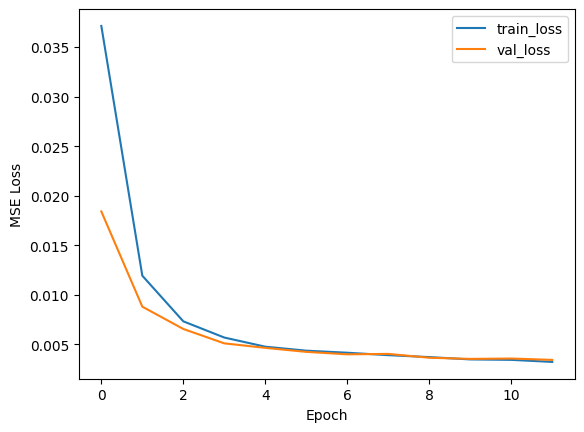

In [8]:
import os
import matplotlib.pyplot as plt

# 1) Load best weights saved by checkpoint
if os.path.exists(CKPT_PATH):
    autoencoder.load_weights(CKPT_PATH)
    print("✅ Loaded best weights from:", CKPT_PATH)
else:
    print("❌ Checkpoint not found:", CKPT_PATH)

# 2) Plot loss curves
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


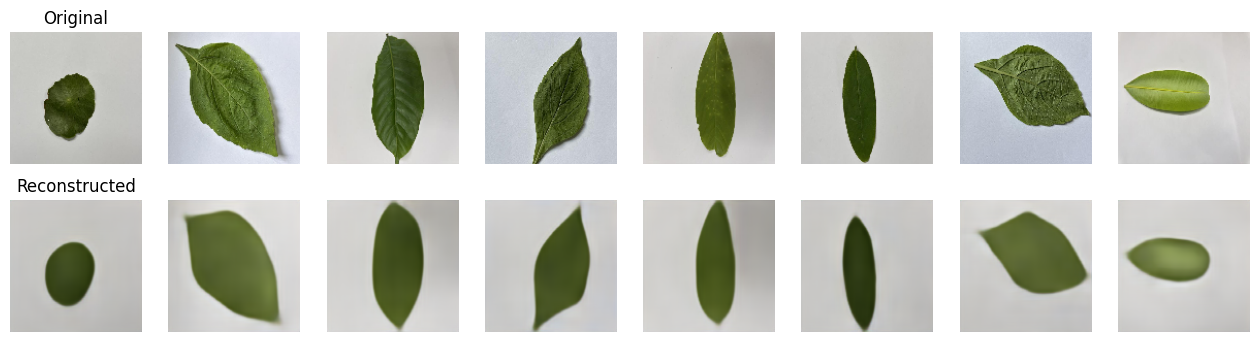

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def show_reconstructions(model, data, n=8):
    idx = np.random.choice(len(data), n, replace=False)
    sample = data[idx]
    recon = model.predict(sample, verbose=0)

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(sample[i])
        plt.axis("off")
        if i == 0: ax.set_title("Original")

        ax = plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i])
        plt.axis("off")
        if i == 0: ax.set_title("Reconstructed")
    plt.show()

show_reconstructions(autoencoder, X_val, n=8)


In [10]:
import tensorflow as tf
import numpy as np

val_recon = autoencoder.predict(X_val, batch_size=32, verbose=0)

mse  = tf.reduce_mean(tf.math.squared_difference(X_val, val_recon)).numpy()
psnr = tf.reduce_mean(tf.image.psnr(X_val, val_recon, max_val=1.0)).numpy()
ssim = tf.reduce_mean(tf.image.ssim(X_val, val_recon, max_val=1.0)).numpy()

print("✅ Validation MSE :", mse)
print("✅ Validation PSNR:", psnr)
print("✅ Validation SSIM:", ssim)

✅ Validation MSE : 0.0034431764
✅ Validation PSNR: 25.174683
✅ Validation SSIM: 0.81476414


In [11]:
import os

AUTO_PATH = os.path.join(OUT_DIR, "autoencoder.keras")
ENC_PATH  = os.path.join(OUT_DIR, "encoder.keras")

autoencoder.save(AUTO_PATH)
encoder.save(ENC_PATH)

print("✅ Saved autoencoder:", AUTO_PATH)
print("✅ Saved encoder     :", ENC_PATH)
print("Files in OUT_DIR:", os.listdir(OUT_DIR))


✅ Saved autoencoder: /content/drive/MyDrive/leaf_cbir_outputs/autoencoder.keras
✅ Saved encoder     : /content/drive/MyDrive/leaf_cbir_outputs/encoder.keras
Files in OUT_DIR: ['ae_best.weights.h5', 'autoencoder.keras', 'encoder.keras']


In [12]:
import numpy as np
import os

# 1) Compute embeddings for all images
embeddings = encoder.predict(images, batch_size=32, verbose=0)

# 2) Normalize for cosine similarity (better retrieval)
embeddings_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-9)

# 3) Save embeddings
EMB_PATH = os.path.join(OUT_DIR, "embeddings.npy")
np.save(EMB_PATH, embeddings_norm)

# 4) Save filepaths (so we know which embedding belongs to which image)
PATHS_TXT = os.path.join(OUT_DIR, "filepaths.txt")
with open(PATHS_TXT, "w") as f:
    for p in filepaths:
        f.write(p + "\n")

print("✅ Saved embeddings:", EMB_PATH, "shape:", embeddings_norm.shape)
print("✅ Saved filepaths :", PATHS_TXT, "count:", len(filepaths))
print("Files in OUT_DIR:", os.listdir(OUT_DIR))


✅ Saved embeddings: /content/drive/MyDrive/leaf_cbir_outputs/embeddings.npy shape: (6096, 256)
✅ Saved filepaths : /content/drive/MyDrive/leaf_cbir_outputs/filepaths.txt count: 6096
Files in OUT_DIR: ['ae_best.weights.h5', 'autoencoder.keras', 'encoder.keras', 'embeddings.npy', 'filepaths.txt']


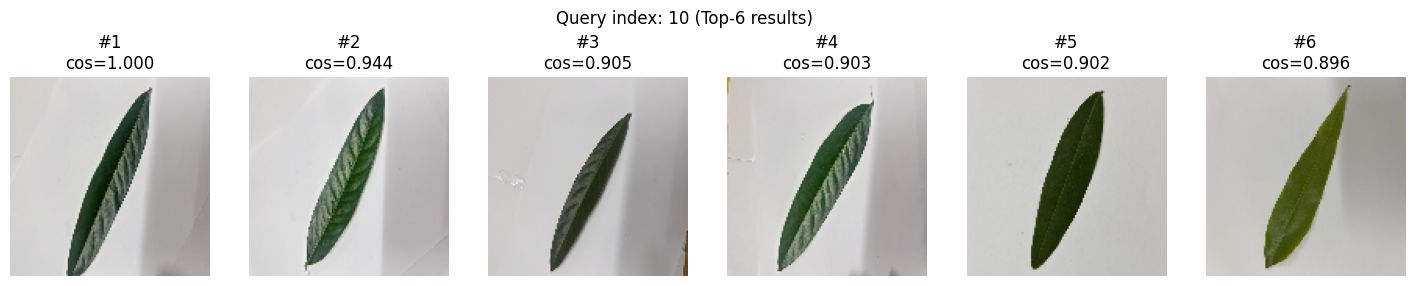

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load index (just to confirm)
emb = np.load(EMB_PATH)

def retrieve_topk(query_index, top_k=6):
    q = emb[query_index]              # already normalized
    sims = emb @ q                    # cosine similarity
    rank = np.argsort(-sims)[:top_k]  # highest similarity first
    return rank, sims[rank]

def show_retrieval(query_index=0, top_k=6):
    idxs, scores = retrieve_topk(query_index, top_k)

    plt.figure(figsize=(3*top_k, 3))
    for i, (ix, sc) in enumerate(zip(idxs, scores)):
        ax = plt.subplot(1, top_k, i+1)
        plt.imshow(images[ix])
        plt.axis("off")
        plt.title(f"#{i+1}\ncos={sc:.3f}")
    plt.suptitle(f"Query index: {query_index} (Top-{top_k} results)", y=1.05)
    plt.show()

# Change query_index to try different leaf images
show_retrieval(query_index=10, top_k=6)


In [14]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()  # upload a jpg/png query leaf image


Saving neem_69.jpg to neem_69.jpg


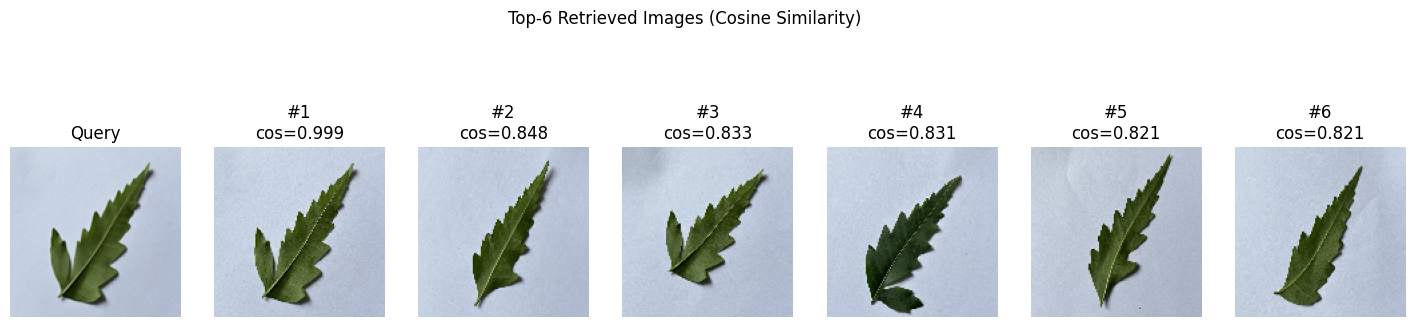

Top retrieved file paths:
1 /content/drive/MyDrive/Medicinal_Leaf_Dataset/Neem/neem_69.jpg  | cos = 0.9990100264549255
2 /content/drive/MyDrive/Medicinal_Leaf_Dataset/Neem/neem_156.jpg  | cos = 0.847598671913147
3 /content/drive/MyDrive/Medicinal_Leaf_Dataset/Neem/neem_84.jpg  | cos = 0.8328784108161926
4 /content/drive/MyDrive/Medicinal_Leaf_Dataset/Neem/neem_64.jpg  | cos = 0.8309420943260193
5 /content/drive/MyDrive/Medicinal_Leaf_Dataset/Neem/neem_426.jpg  | cos = 0.8207218647003174
6 /content/drive/MyDrive/Medicinal_Leaf_Dataset/Neem/neem_379.jpg  | cos = 0.8206735253334045


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) Load uploaded image (take first uploaded file)
uploaded_name = list(uploaded.keys())[0]
query_pil = Image.open(uploaded_name).convert("RGB")
query_pil = query_pil.resize((IMG_SIZE, IMG_SIZE))

query_arr = np.array(query_pil).astype("float32") / 255.0

# 2) Get query embedding
q = np.expand_dims(query_arr, axis=0)
q_emb = encoder.predict(q, verbose=0)[0]
q_emb = q_emb / (np.linalg.norm(q_emb) + 1e-9)  # normalize

# 3) Cosine similarity with all embeddings
sims = emb @ q_emb
rank = np.argsort(-sims)[:6]

# 4) Show query + results
plt.figure(figsize=(18, 4))

# Query
ax = plt.subplot(1, 7, 1)
plt.imshow(query_arr)
plt.axis("off")
plt.title("Query")

# Top results
for i, ix in enumerate(rank):
    ax = plt.subplot(1, 7, i+2)
    plt.imshow(images[ix])
    plt.axis("off")
    plt.title(f"#{i+1}\ncos={sims[ix]:.3f}")

plt.suptitle("Top-6 Retrieved Images (Cosine Similarity)", y=1.05)
plt.show()

print("Top retrieved file paths:")
for i, ix in enumerate(rank):
    print(i+1, filepaths[ix], " | cos =", float(sims[ix]))
